In [9]:
#import libraries and setup sql cursor
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
import requests 
import matplotlib.pyplot as plt

conn = sqlite3.connect('data/movies.db')
cur = conn.cursor()

## Get bom and rotten tomatoe data and merge them into one with overlapping values(inner)

In [10]:
#get rotten tomatoe data
rt_movies = pd.DataFrame(cur.execute("SELECT * FROM rotten_tomatoes_movies").fetchall())
rt_movies.columns = [i[0] for i in cur.description]

In [11]:
#get bom movie data
bom_movie_gross = pd.DataFrame(cur.execute("SELECT foreign_gross, domestic_gross, title from bom_movie_gross").fetchall())
bom_movie_gross.columns = [i[0] for i in cur.description]
bom_movie_gross = bom_movie_gross[bom_movie_gross["foreign_gross"].notna()]

In [12]:
#create merged dataframe of rotten tomatoe and bom movies
bom_gross_rt_genre = rt_movies.join(bom_movie_gross, how="inner")

In [13]:
#drop na values from rotten tomatoe and bom movie merge
bom_gross_rt_genre.dropna(inplace=True)

In [14]:
not_list_format =  bom_gross_rt_genre

In [15]:
#sc
not_list_format.head()

,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,foreign_gross,domestic_gross,title
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,149.0,Spilled,53.0,254421.0,43,73,76,652000000,415000000.0,Toy Story 3
1,1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",...,142.0,Upright,64.0,11574.0,44,123,19,691300000,334200000.0,Alice in Wonderland (2010)
2,2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",...,24.0,Spilled,53.0,14684.0,2,16,8,664300000,296000000.0,Harry Potter and the Deathly Hallows Part 1
3,3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",...,54.0,Upright,97.0,105386.0,6,54,0,535700000,292600000.0,Inception
4,4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",...,27.0,Upright,74.0,68918.0,5,24,3,513900000,238700000.0,Shrek Forever After


In [16]:
#group by genres to show mean of domestic gross by get
#bom_gross_rt_genre.groupby(["genres"])["domestic_gross"].mean()

In [17]:
#reformat genres data go make it a list of items
genres = bom_gross_rt_genre["genres"].str.replace("&", ",")
genres = bom_gross_rt_genre["genres"].str.split(',')
#bom_gross_rt_genre["genres"] = bom_gross_rt_genre["genres"].str.strip(" ")

## get list of unique genres

In [19]:
#make list of genres so I can get unique ones
all_genres = []
for item in genres:
    if item != None:
        for genre in item:
            all_genres.append(genre)
unique_genres = set(all_genres)

In [20]:
unique_genres = set([(genre.strip()) for genre in unique_genres])

In [21]:
#sc
unique_genres

{'Action & Adventure',
 'Animation',
 'Art House & International',
 'Classics',
 'Comedy',
 'Cult Movies',
 'Documentary',
 'Drama',
 'Faith & Spirituality',
 'Horror',
 'Kids & Family',
 'Musical & Performing Arts',
 'Mystery & Suspense',
 'Romance',
 'Science Fiction & Fantasy',
 'Special Interest',
 'Sports & Fitness',
 'Television',
 'Western'}

## Get data based off a certain genre from bom and rotten tomatoe merge

In [59]:
test = not_list_format[not_list_format["genres"].str.contains("Comedy")]

test[]

,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,foreign_gross,domestic_gross,title
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,149.0,Spilled,53.0,254421.0,43,73,76,652000000.0,415000000.0,Toy Story 3
1,1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",...,142.0,Upright,64.0,11574.0,44,123,19,691300000.0,334200000.0,Alice in Wonderland (2010)
2,2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",...,24.0,Spilled,53.0,14684.0,2,16,8,664300000.0,296000000.0,Harry Potter and the Deathly Hallows Part 1
14,14,m/1000253-adams_rib,Adam's Rib,A courtroom rivalry finds its way into the hou...,"Matched by Garson Kanin's witty, sophisticated...",NR,"Classics, Comedy, Romance",George Cukor,"Garson Kanin, Ruth Gordon","Spencer Tracy, Katharine Hepburn, Judy Hollida...",...,28.0,Upright,86.0,10563.0,6,27,1,182500000.0,176600000.0,The Karate Kid
37,37,m/10004925-matador,The Matador,Salesman Danny Wright (Greg Kinnear) is workin...,"This humorously amoral, oddball comic thriller...",R,"Action & Adventure, Comedy, Drama, Mystery & S...","Bob Yari, Richard Shepard","Richard Shepard, Richard Shepherd","Pierce Brosnan, Greg Kinnear, Hope Davis, Phil...",...,156.0,Upright,65.0,73701.0,39,117,39,101300000.0,100200000.0,Yogi Bear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3222,3222,m/bathtubs_over_broadway,Bathtubs Over Broadway,Writer Steve Young tracks down rare musical sh...,Bathtubs Over Broadway pulls back the curtains...,PG-13,"Comedy, Documentary",Dava Whisenant,"Dava Whisenant, Ozzy Inguanzo","David Letterman, Chita Rivera, Martin Short, F...",...,35.0,Upright,91.0,161.0,11,35,0,10900000.0,1300000.0,102 Not Out
3261,3261,m/battle_of_the_sexes,Battle of the Sexes,The 1973 tennis match between Billie Jean King...,Battle of the Sexes turns real-life events int...,PG-13,"Comedy, Drama, Sports & Fitness","Jonathan Dayton, Valerie Faris",Simon Beaufoy,"Emma Stone, Steve Carell, Andrea Riseborough, ...",...,310.0,Upright,71.0,15804.0,55,263,48,3100000.0,200000.0,Gauguin: Voyage to Tahiti
3275,3275,m/be_cool,Be Cool,Having made the transition from gangster to mo...,"Be Cool is tepid, square, and lukewarm; as a p...",PG-13,"Comedy, Drama, Mystery & Suspense",F. Gary Gray,Peter Steinfeld,"John Travolta, Uma Thurman, Vince Vaughn, Cedr...",...,172.0,Spilled,42.0,212599.0,39,52,120,1500000.0,1400.0,I Still See You
3286,3286,m/bean,Bean,"At the Royal National Gallery in London, the b...",Bean boasts a terrifically talented physical c...,PG-13,Comedy,Mel Smith,"Robin Driscoll, Richard Curtis, Rowan Atkinson","Rowan Atkinson, Peter MacNicol, Pamela Reed, H...",...,34.0,Spilled,53.0,340424.0,11,15,19,229000.0,725000.0,The Catcher Was a Spy


In [34]:
#turn string values within foreign gross column into na and drop them
not_list_format["foreign_gross"] = not_list_format["foreign_gross"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

## for loop through unique genres and get a mean gross for each to add to graph

In [35]:
d_gross = []
f_gross = []

for genre in unique_genres:
    frame = not_list_format[not_list_format["genres"].str.contains(genre)]
    mean_d_gross = round(frame["domestic_gross"].mean(), 1)
    mean_f_gross = round(frame["foreign_gross"].mean(), 1)
    d_gross.append(mean_d_gross)
    f_gross.append(mean_f_gross)

In [36]:
#turn gross lists and unique genres into dictionary in one variable
genre_grossing_dict = {"genre": list(unique_genres), "domestic_gross": d_gross, "foreign_gross": f_gross}

In [37]:
#genre_grossing = pd.DataFrame(genre_averages, columns =['genre', 'domestic_gross', 'foreign_gross'])
genre_grossing = pd.DataFrame(genre_grossing_dict)
# genre_grossing["genre"] = genre_averages.keys()
# genre_grossing["genre"] = [item[0] for item in genre_grossing.values()]

In [38]:
#set genres as index so I can drop stuff based on it
#genre_grossing.set_index("genre")

In [39]:
genre_grossing = genre_grossing[genre_grossing["genre"] != 'Cult Movies']
genre_grossing = genre_grossing[genre_grossing["genre"] != 'Television']
genre_grossing = genre_grossing[genre_grossing["genre"] != 'Classics']
genre_grossing = genre_grossing[genre_grossing["genre"] != 'Art House & International']

In [40]:
genre_grossing.sort_values("domestic_gross", ascending=False, inplace=True)

Text(0, 0.5, 'Genre')

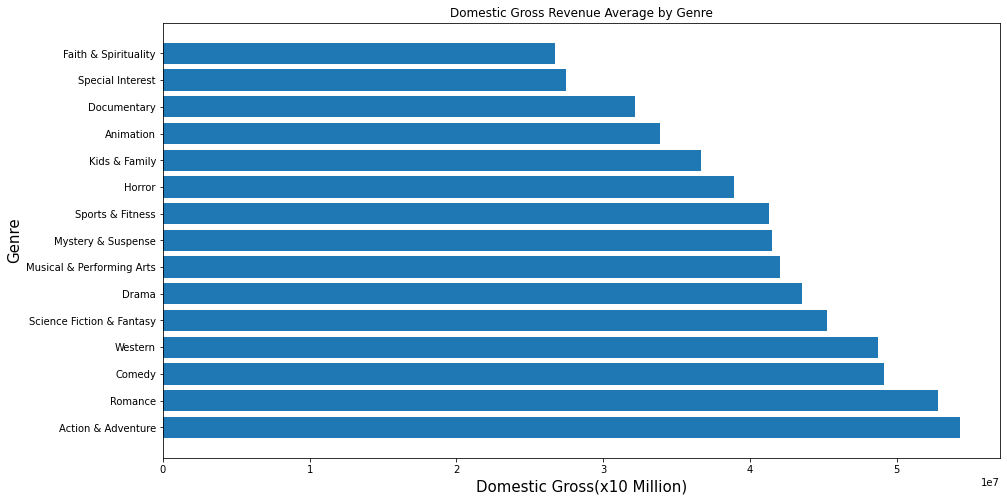

In [42]:
#make graph of mean gross by genre
fig, ax = plt.subplots(figsize= (15, 8))
ax.barh(genre_grossing["genre"], genre_grossing["domestic_gross"])
ax.set_title("Domestic Gross Revenue Average by Genre")
ax.set_xlabel("Domestic Gross(x10 Million)",fontsize=15)
ax.set_ylabel("Genre",fontsize=15)

In [43]:
url = 'https://www.imdb.com/title/tt0088247/'

In [44]:
response = requests.get(url)

In [47]:
soup = BeautifulSoup(response.text)

In [58]:
soup.find('div', {'data-testid': 'title-boxoffice-section'})\
.find('li', {'role': 'presentation'})\
# .find('span', {'class': 'ipc-metadata-list-item__list-content-item'}).text

<li class="ipc-metadata-list__item BoxOffice__MetaDataListItemBoxOffice-sc-40s2pl-2 gwNUHl" data-testid="title-boxoffice-budget" role="presentation"><span class="ipc-metadata-list-item__label">Budget</span><div class="ipc-metadata-list-item__content-container"><ul class="ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content base" role="presentation"><li class="ipc-inline-list__item" role="presentation"><span class="ipc-metadata-list-item__list-content-item">$6,400,000 (estimated)</span></li></ul></div></li>